--
[[10, 15, 14, 21, 20], [19, 7, 12, 17], [22, 23, 4, 3, 0], [24, 14, 16, 18, 25], [5, 26, 27], [9, 1, 0, 3, 2, 8], [12, 7, 6, 4, 3, 2, 11], [13, 8, 2, 11], [28, 29, 0, 1], [19, 7, 6, 5, 30, 31, 18], [17, 12, 11, 13, 15, 14, 16], [32, 1, 9, 10, 33], [4, 34, 35, 5, 6], [19, 17, 16, 18], [15, 10, 9, 8, 13]]
--
[[ 0.51204146  0.28170809]
 [ 0.31568864  0.2231658 ]
 [ 0.60181497  0.48198612]
 [ 0.61195783  0.46638446]
 [ 0.76349576  0.49961565]
 [ 0.86163554  0.77300743]
 [ 0.82428491  0.74711566]
 [ 0.5955872   0.86737793]
 [ 0.3398531   0.5360898 ]
 [ 0.20717026  0.45505837]
 [ 0.19839983  0.46568522]
 [ 0.54203769  0.60556533]
 [ 0.52991347  0.64525971]
 [ 0.34632775  0.58619376]
 [ 0.28095359  0.68979933]
 [ 0.27956806  0.65401536]
 [ 0.32776593  0.71199644]
 [ 0.40994669  0.69667456]
 [ 0.41517255  1.51501742]
 [ 0.46233568  1.32637502]
 [-0.66003117  0.85930004]
 [-0.57288882  1.0932712 ]
 [ 1.15692347 -0.40819306]
 [ 1.63900083  0.14559972]
 [-0.57288882  1.0932712 ]
 [ 0.26349769 

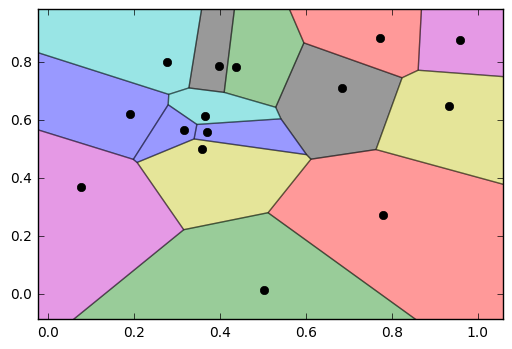

In [12]:
plt.clf()
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

# make up data points
np.random.seed(1234)
points = np.random.rand(15, 2)

# compute Voronoi tesselation
vor = Voronoi(points)

# plot
regions, vertices = voronoi_finite_polygons_2d(vor)
print "--"
print regions
print "--"
print vertices

# colorize
for region in regions:
    polygon = vertices[region]
    plt.fill(*zip(*polygon), alpha=0.4)

plt.plot(points[:,0], points[:,1], 'ko')
plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)

plt.show()

## code to generate gif from 2D data

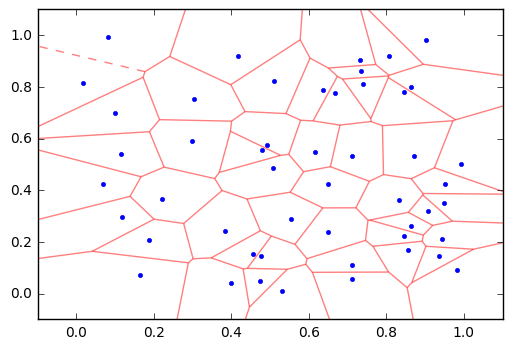

In [74]:
from __future__ import division, print_function, absolute_import

import numpy as np
 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def _adjust_bounds(ax, points):
    ptp_bound = points.ptp(axis=0)
    ax.set_xlim(points[:,0].min() - 0.1*ptp_bound[0],
                points[:,0].max() + 0.1*ptp_bound[0])
    ax.set_ylim(points[:,1].min() - 0.1*ptp_bound[1],
                points[:,1].max() + 0.1*ptp_bound[1])

def voronoi_plot_2d_rew(vor, **kw):
    from matplotlib.collections import LineCollection
    if vor.points.shape[1] != 2:
        raise ValueError("Voronoi diagram is not 2-D")
    line_colors = kw.get('line_colors', 'k')
    line_width = kw.get('line_width', 1.0)
    line_alpha = kw.get('line_alpha', 1.0)
    line_segments = []
    for simplex in vor.ridge_vertices:
        simplex = np.asarray(simplex)
        if np.all(simplex >= 0):
            line_segments.append([(x, y) for x, y in vor.vertices[simplex]])
    lcS = LineCollection(line_segments,
                        colors=line_colors,
                        lw=line_width,
                        linestyle='solid')
    lcS.set_alpha(line_alpha)   
    ptp_bound = vor.points.ptp(axis=0)
    line_segments = []
    center = vor.points.mean(axis=0)
    for pointidx, simplex in zip(vor.ridge_points, vor.ridge_vertices):
        simplex = np.asarray(simplex)
        if np.any(simplex < 0):
            i = simplex[simplex >= 0][0]  # finite end Voronoi vertex
            t = vor.points[pointidx[1]] - vor.points[pointidx[0]]  # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal
            midpoint = vor.points[pointidx].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[i] + direction * ptp_bound.max()
            line_segments.append([(vor.vertices[i, 0], vor.vertices[i, 1]),
                                  (far_point[0], far_point[1])])
    lcD = LineCollection(line_segments,
                        colors=line_colors,
                        lw=line_width,
                        linestyle='dashed')
    lcD.set_alpha(line_alpha)       
    return lcS,lcD,vor,

def animate(im):
    ax = fig.gca()
    ax.cla()
    ax.add_collection(im[0])
    ax.add_collection(im[1])# update the data
    vor=im[2]
    #next line plot vertices
    #ax.plot(vor.vertices[:,0], vor.vertices[:,1], 'o')
    #next line plot points
    ax.plot(vor.points[:,0], vor.points[:,1], '.')
    _adjust_bounds(ax,np.concatenate((vor.points, np.array([[0,0],[1,1]])), axis=0))
    return ax.figure,




###################################################################################################################
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.spatial import Voronoi
fig = plt.figure()

ims = []
for i in range(10):
    data=np.random.rand(50, 2)
    vor=Voronoi(data, incremental=True)
    ims.append(voronoi_plot_2d_rew(vor,show_points=True,show_vertices=True,line_alpha=0.5,line_colors='red'))
    
ani = animation.FuncAnimation(fig, animate, ims,interval=80, blit=True)
ani.save('line.gif', dpi=80, writer='imagemagick')
plt.show()
